# 11252019_siHNRNPA1_tRF_stability_RNA-seq

In [1]:
%%bash
ls 
# nohup bash -c 'code' > out.txt&

bam
conditions.txt
conditions.xlsx
fastq
nohup.out
notebook.ipynb
trim


### Trimming task

In [ ]:
%%bash
# Trimming task
for f in fastq/*_R1_001.fastq.gz; do
    out=${f/fastq/trim}
    out=${out/_001.fastq.gz/.trim.fastq.gz}
    echo cutadapt -j 12 -q 15 -m 20 -a AGATCGGAAGAGCACACGTCTGAACTCCAGTCA -o $out $f
done

### Alignment task

In [ ]:
%%bash
for f in trim/*_R1.trim.fastq.gz; do
    out=${f/trim/bam}
    out=${out/_R1.trim.fastq.gz/_}
    echo STAR --outSAMtype BAM SortedByCoordinate --readFilesCommand zcat --runThreadN 1 --sjdbGTFfile /rumi/shams/genomes/hg38/hg38_genes.gtf  --genomeDir /rumi/shams/genomes/hg38 --readFilesIn $f --outFileNamePrefix $out
done 

### Measure counts

In [5]:
%%bash
for f in bam/*_Aligned.sortedByCoord.out.bam; do
    out=${f/bam/count}
    out=${out/_Aligned.sortedByCoord.out.bam/.gene.fc}
    featureCounts -T 12 -O -t exon -g gene_id -a /rumi/shams/genomes/hg38/hg38_genes.gtf -o $out $f;
done

# Load R

In [6]:
%load_ext rpy2.ipython

In [9]:
%%R
library(DESeq2,  quietly = TRUE)
library(ggplot2, quietly = TRUE)
library(ggrepel, quietly = TRUE)
library(EnhancedVolcano, quietly = TRUE)
# library(ggpubr, quietly = TRUE)

In [12]:
%%bash
cat conditions.txt

BATCH	sample number	barcode	replicate	timepoint	siRNA	LNA
1	1	ATGTCA	1	0	siCtrl	Scr
1	2	CCGTCC	2	0	siCtrl	Scr
1	3	GTCCGC	1	0	siCtrl	Tyr
1	4	GTGAAA	2	0	siCtrl	Tyr
1	5	ATCACG	1	0	siHNRNPa1	Scr
1	6	TTAGGC	2	0	siHNRNPa1	Scr
1	7	ACTTGA	1	0	siHNRNPa1	Tyr
1	8	GATCAG	2	0	siHNRNPa1	Tyr
1	9	CGATGT	1	8	siCtrl	Scr
1	10	TGACCA	2	8	siCtrl	Scr
1	11	ACAGTG	1	8	siCtrl	Tyr
1	12	GCCAAT	2	8	siCtrl	Tyr
1	13	CAGATC	1	8	siHNRNPa1	Scr
1	14	CTTGTA	2	8	siHNRNPa1	Scr
1	15	AGTCAA	1	8	siHNRNPa1	Tyr
1	16	AGTTCC	2	8	siHNRNPa1	Tyr

## Read data 

In [41]:
%%R
files <- list.files(path = 'count', pattern=".fc$")
files <- files[c(1,9:16, 2:8)]

replicate <- rep(c('rep_1', 'rep_2'),8)
timepoint <- c(rep('t0',8), rep('t8',8))
siRNA <- rep(c(rep('siCtrl',4),rep('siHNRNPa1',4)),2)
LNA <- rep(c(rep('Scr',2),rep('Tyr',2)),4)
all_cond <- paste(siRNA, timepoint, LNA, replicate, sep="_")
cond <- paste(siRNA, timepoint, LNA, sep="_")

datalist <- lapply(files, function(x){read.table(file=paste('count',x,sep = '/'),header=TRUE,colClasses=c(NA, "NULL", "NULL", "NULL", "NULL", "NULL", NA),check.names=F)})
m <- Reduce(function(...) merge(..., by=1, all = TRUE), datalist)
rownames(m) <- m[,1]
m <- m[,-1]
m[is.na(m)]<-0
m <- round(m)
colnames(m) <- paste('S', 1:16, sep = '')
colData <- data.frame(cond, row.names=colnames(m))
colData

                cond
S1     siCtrl_t0_Scr
S2     siCtrl_t0_Scr
S3     siCtrl_t0_Tyr
S4     siCtrl_t0_Tyr
S5  siHNRNPa1_t0_Scr
S6  siHNRNPa1_t0_Scr
S7  siHNRNPa1_t0_Tyr
S8  siHNRNPa1_t0_Tyr
S9     siCtrl_t8_Scr
S10    siCtrl_t8_Scr
S11    siCtrl_t8_Tyr
S12    siCtrl_t8_Tyr
S13 siHNRNPa1_t8_Scr
S14 siHNRNPa1_t8_Scr
S15 siHNRNPa1_t8_Tyr
S16 siHNRNPa1_t8_Tyr


# DE Analysis

In [53]:
%%R
dds <- DESeqDataSetFromMatrix(countData = m, colData = colData, design = ~ cond)
dds$cond<- relevel(dds$cond, ref="siCtrl_t0_Scr")
dds <- DESeq(dds)
ncu <- counts(dds, normalized=TRUE)
write.table(ncu, file="DESeq/gene_count_table_DE2norm.txt", sep="\t", quote=FALSE, col.names=all_cond) 
write.table(m, file="DESeq/gene_count_table_raw.txt", sep="\t", quote=FALSE, col.names=all_cond)
cds <- estimateDispersions(dds)
vsd <- varianceStabilizingTransformation(cds)
resultsNames(dds)

R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: found already estimated dispersions, replacing these

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates



[1] "Intercept"                             
[2] "cond_siCtrl_t0_Tyr_vs_siCtrl_t0_Scr"   
[3] "cond_siCtrl_t8_Scr_vs_siCtrl_t0_Scr"   
[4] "cond_siCtrl_t8_Tyr_vs_siCtrl_t0_Scr"   
[5] "cond_siHNRNPa1_t0_Scr_vs_siCtrl_t0_Scr"
[6] "cond_siHNRNPa1_t0_Tyr_vs_siCtrl_t0_Scr"
[7] "cond_siHNRNPa1_t8_Scr_vs_siCtrl_t0_Scr"
[8] "cond_siHNRNPa1_t8_Tyr_vs_siCtrl_t0_Scr"


### PCA 

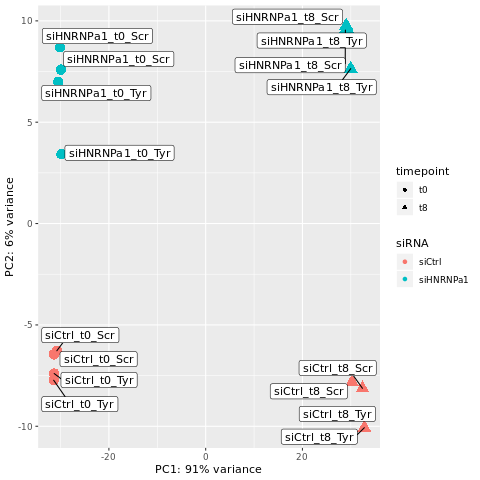

In [46]:
%%R
z <- plotPCA(vsd,intgroup=c("cond"), returnData=TRUE)
percentVar <- round(100 * attr(z, "percentVar"))
p <- ggplot(z, aes(PC1, PC2)) +
  geom_point(aes(size = 4, color = siRNA, shape = timepoint)) +
  xlab(paste0("PC1: ",percentVar[1],"% variance")) +
  ylab(paste0("PC2: ",percentVar[2],"% variance")) +
  geom_label_repel(label = cond, force = 10) +
#   labs(shape="Time point", colour="") +
  guides(size = FALSE)
print (p)

### Model 
#### (Tyr8-Tye0) -  (Scr8-Scr0)) in siControl - ((Tyr8-Tye0) -  (Scr8-Scr0)) in siHNRNA1)

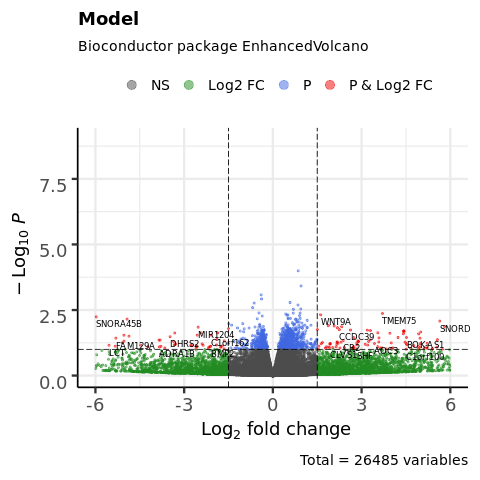

In [83]:
%%R
res <- results(dds, contrast=list(
                # positive 
                c("cond_siCtrl_t8_Tyr_vs_siCtrl_t0_Scr",
                  "cond_siHNRNPa1_t0_Tyr_vs_siCtrl_t0_Scr",
                  "cond_siHNRNPa1_t8_Scr_vs_siCtrl_t0_Scr")
                # negative 
                ,c("cond_siCtrl_t0_Tyr_vs_siCtrl_t0_Scr",
                   "cond_siCtrl_t8_Scr_vs_siCtrl_t0_Scr",
                   "cond_siHNRNPa1_t8_Tyr_vs_siCtrl_t0_Scr",
                   "cond_siHNRNPa1_t0_Scr_vs_siCtrl_t0_Scr")), listValues=c(1,-1))
write.table(res, "DESeq/Model.txt", sep="\t", quote=FALSE, col.names=NA )
# Volcano plot 
vol <- EnhancedVolcano(res,
    lab = rownames(res),
    x = 'log2FoldChange',
    y = 'pvalue',
    xlim = c(-6, 6),
    title = 'Model',
    pCutoff = 10e-2,
    FCcutoff = 1.5)
print (vol)

       baseMean log2FoldChange     lfcSE      stat       pvalue padj
SNHG7  1090.364      0.8600934 0.2211727  3.888787 0.0001007465    1
KLF5   2201.955      0.9549195 0.2688335  3.552085 0.0003821907    1
NOP58  6587.340     -0.3951541 0.1182825 -3.340764 0.0008354815    1
MAPRE1 5624.979     -0.3817548 0.1178518 -3.239279 0.0011983213    1
SMAD3  1271.579      0.5812006 0.1844441  3.151094 0.0016266007    1
GOLGA4 3723.395     -0.6298438 0.2009070 -3.135001 0.0017185336    1


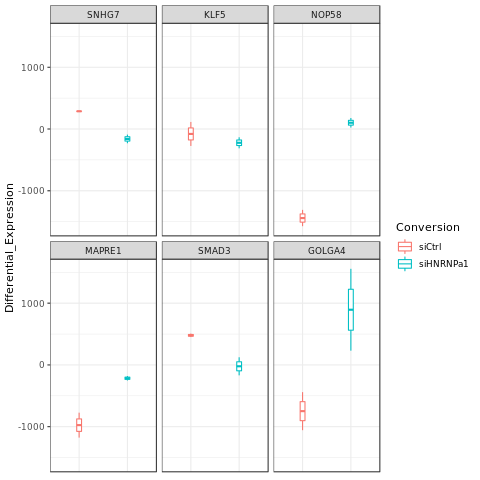

In [92]:
%%R
# check top genes 
top_genes <- rownames(head(res[order(res$pvalue),]))
myplots <- list() 
check <- data.frame()
for (g in 1:length(top_genes)){
    check <- rbind(check,data.frame(
            'Differential_Expression' = c(
                # (Tyr8-Tye0) - (Scr8-Scr0)) in siControl 
               (ncu[top_genes[g],rownames(subset (colData,cond == 'siCtrl_t8_Tyr'))] -
                ncu[top_genes[g],rownames(subset (colData,cond == 'siCtrl_t0_Tyr'))])-
               (ncu[top_genes[g],rownames(subset (colData,cond == 'siCtrl_t8_Scr'))] -
                ncu[top_genes[g],rownames(subset (colData,cond == 'siCtrl_t0_Scr'))]),
                # (Tyr8-Tye0) - (Scr8-Scr0)) in siHNRNA1
               (ncu[top_genes[g],rownames(subset (colData,cond == 'siHNRNPa1_t8_Tyr'))] -
                ncu[top_genes[g],rownames(subset (colData,cond == 'siHNRNPa1_t0_Tyr'))])-
               (ncu[top_genes[g],rownames(subset (colData,cond == 'siHNRNPa1_t8_Scr'))] -
                ncu[top_genes[g],rownames(subset (colData,cond == 'siHNRNPa1_t0_Scr'))])),
            'Conversion' = c(rep('siCtrl',2), rep('siHNRNPa1' ,2)), 'Gene' = top_genes[g]))
}
print(data.frame (head(res[order(res$pvalue),])))
ggplot(data = check, mapping = aes(x = Conversion, y = Differential_Expression, color = Conversion)) +
    geom_boxplot(width=0.1)+
    scale_fill_grey() +
    theme_bw() +
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank())+
    facet_wrap(facets = vars(Gene))